In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load data

In [3]:
df_raw = pd.read_csv('../data/fairlymade_products_impacts.csv')

## Dataset analysis

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8919 entries, 0 to 8918
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   study_id               8919 non-null   object 
 1   product_type           8919 non-null   object 
 2   nb_components          8919 non-null   int64  
 3   composition            8914 non-null   object 
 4   raw_material_country   877 non-null    object 
 5   weaving_country        4167 non-null   object 
 6   dyeing_country         7342 non-null   object 
 7   manufacturing_country  8919 non-null   object 
 8   plane_in_transports    8919 non-null   bool   
 9   climate_change         8919 non-null   float64
 10  resource_use_fossils   8918 non-null   float64
dtypes: bool(1), float64(2), int64(1), object(7)
memory usage: 705.6+ KB


In [9]:
df_raw.sample(5)

,study_id,product_type,nb_components,composition,raw_material_country,weaving_country,dyeing_country,manufacturing_country,plane_in_transports,climate_change,resource_use_fossils
3158,157d7415-039e-4181-95b4-6f14b12c3478,BLOUSES,1,COTTON,NaN,IN,IN,IN,True,8.043726,105.861054
3426,d077f8ef-db78-4d6d-ad50-860a220cad1b,DRESSES,3,"ZAMAK, COTTON, POLYESTER",NaN,"CN, TH","CN, FR",RO,False,16.235498,225.431531
5306,6db4737e-520d-4b16-82f5-40447d41937b,CARDIGANS,1,CASHMERE,NaN,NaN,CN,CN,False,112.873860,152.388000
5205,c11a37b7-7227-4912-8dee-9e6a4b1d3bc5,TSHIRTS,1,COTTON,NaN,NaN,PT,PT,False,2.227284,43.072466
5424,dd9a2994-948d-41bb-a425-eca470037847,CARDIGANS,1,COTTON,NaN,NaN,FR,FR,False,12.461389,208.684018


In [8]:
df_raw.describe()

,nb_components,climate_change,resource_use_fossils
count,8919.000000,8919.000000,8918.000000
mean,1.563628,22.444302,178.237971
std,0.715199,34.525508,129.616346
min,1.000000,0.341666,0.000000
25%,1.000000,5.738983,81.639080
50%,1.000000,11.708067,146.395439
75%,2.000000,23.898276,235.716986
max,3.000000,558.906266,987.385617


In [251]:
df_raw['product_type'].value_counts()[0:10]

product_type
PULLOVERS              1188
TSHIRTS                 991
DRESSES                 958
SHIRTS                  890
PANTS                   683
JACKETS & WORKVESTS     545
SWEATSHIRTS             403
SKIRTS                  389
DENIM PANTS             342
TOPS                    311
Name: count, dtype: int64

## Column analysis

Here we are trying to get a better understanding of the columns in this dataset.

First observations:
- climate_change and resource_use_fossils seem to be the columns to predict
- Clothes have few components (maximum 3)
- raw_material_country, weaving_country and dyeing_country are the columns with the most missing values
- composition and countries columns can have multiple values per row (we need to unnest these columns)
- study_id is probably not very interesting to use for this study case

In [58]:
# unnest columns with multiple values
df_composition_unnested = df_raw['composition'].str.split(',')
df_composition_unnested

# expand=True

0                        [POLYESTER,  RECYCLED POLYAMIDE]
1                                     [COTTON,  ELASTANE]
2                       [VEGETAL IVORY - COROZO,  COTTON]
3                      [POLYESTER,  ELASTANE,  POLYAMIDE]
4       [RECYCLED BRASS,  RECYCLED POLYESTER,  ZAMAK, ...
                              ...                        
8914    [VISCOSE,  RECYCLED POLYESTER,  VIRGIN WOOL,  ...
8915                          [ELASTANE,  ORGANIC COTTON]
8916                                     [ORGANIC COTTON]
8917                                     [ORGANIC COTTON]
8918                                     [ORGANIC COTTON]
Name: composition, Length: 8919, dtype: object

In [38]:
df_raw['composition'].str.contains('COTTON'])

0       False
1        True
2        True
3       False
4       False
        ...  
8914    False
8915     True
8916     True
8917     True
8918     True
Name: composition, Length: 8919, dtype: object

In [56]:
df_raw['composition'].str.split(', ', expand=True).stack().value_counts()[0:15]

COTTON                3727
POLYESTER             2281
ELASTANE              1921
POLYAMIDE             1364
VISCOSE               1318
ORGANIC COTTON        1126
CASHMERE               924
SILK                   703
FLAX                   653
SHEEP WOOL             531
RECYCLED POLYESTER     525
MERINO WOOL            376
VIRGIN WOOL            291
NYLON                  221
ZAMAK                  218
Name: count, dtype: int64

## Data analysis

### Impact per nb_components

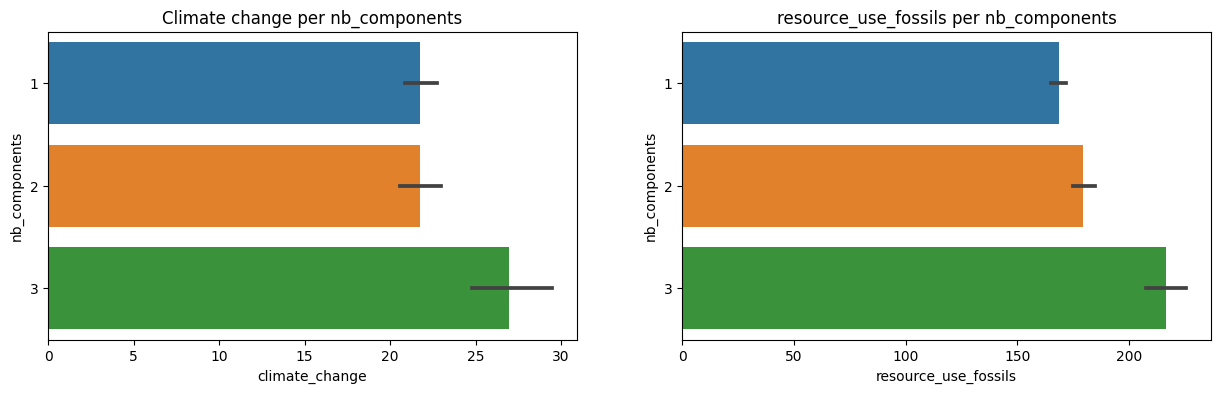

In [87]:
df_ = df_raw.copy()
df_['nb_components'] = df_['nb_components'].astype(str)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(df_, x='climate_change', y='nb_components', order=['1', '2', '3'], errorbar='ci', ax=ax[0])
ax[0].set_title('Climate change per nb_components')

sns.barplot(df_, x='resource_use_fossils', y='nb_components', order=['1', '2', '3'], errorbar='ci', ax=ax[1])
ax[1].set_title('resource_use_fossils per nb_components')

plt.show()

### Impact per product_type

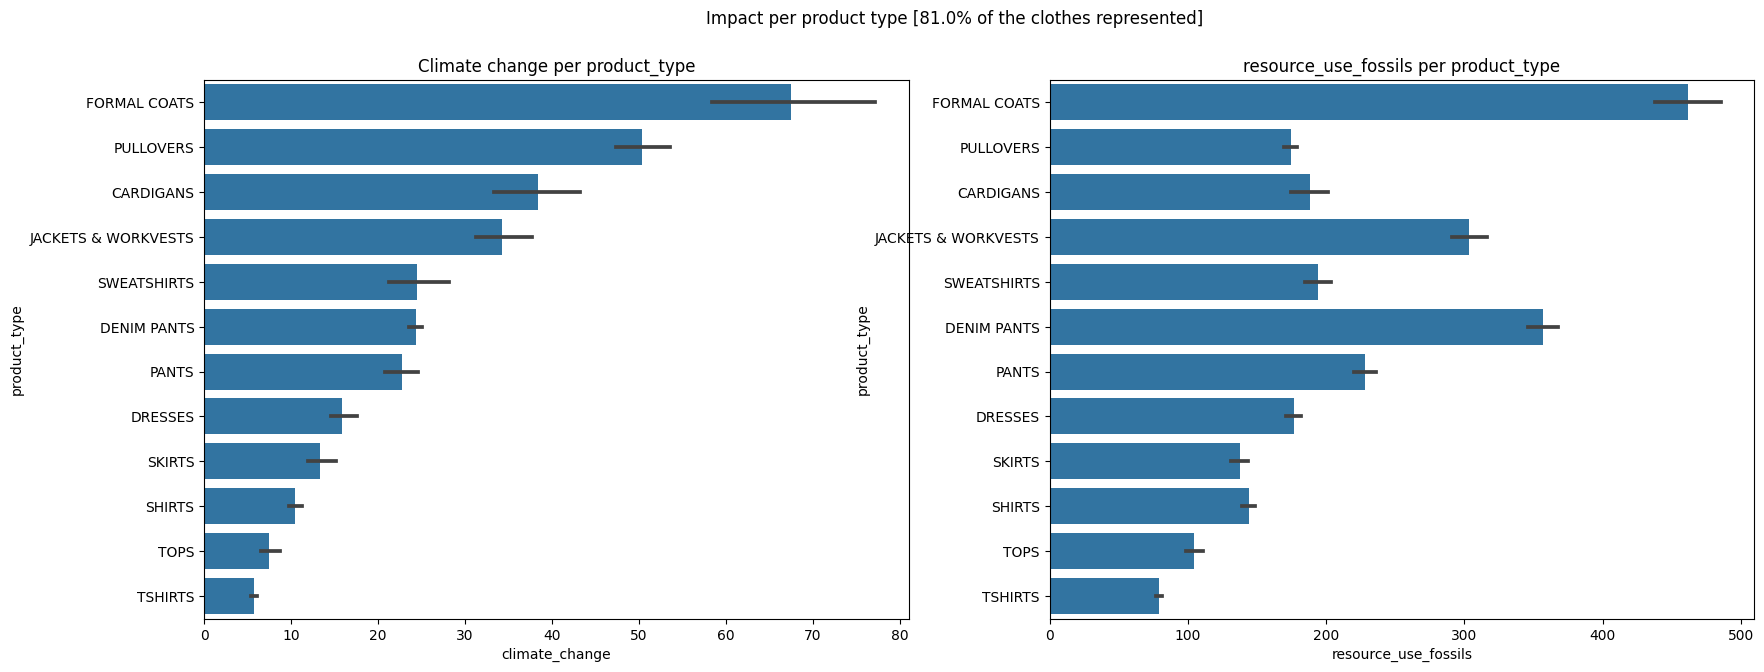

In [132]:
df_ = df_raw.copy()

products_selected = df_['product_type'].value_counts()[0:12].index
selection_ratio = df_['product_type'].value_counts()[0:12].values.sum()/df_['product_type'].value_counts().values.sum()

df_ = df_[df_['product_type'].isin(products_selected)]

order = df_.groupby(['product_type']).agg({'climate_change':'mean'}).sort_values(['climate_change'], ascending=False).index

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.barplot(df_, x='climate_change', y='product_type', order=order, color='tab:blue', errorbar='ci', ax=ax[0])
ax[0].set_title('Climate change per product_type')

sns.barplot(df_, x='resource_use_fossils', y='product_type', order=order, color='tab:blue', errorbar='ci', ax=ax[1])
ax[1].set_title('resource_use_fossils per product_type')

fig.suptitle(f"Impact per product type [{round(selection_ratio*100,0)}% of the clothes represented]")

plt.show()

### Impact per material

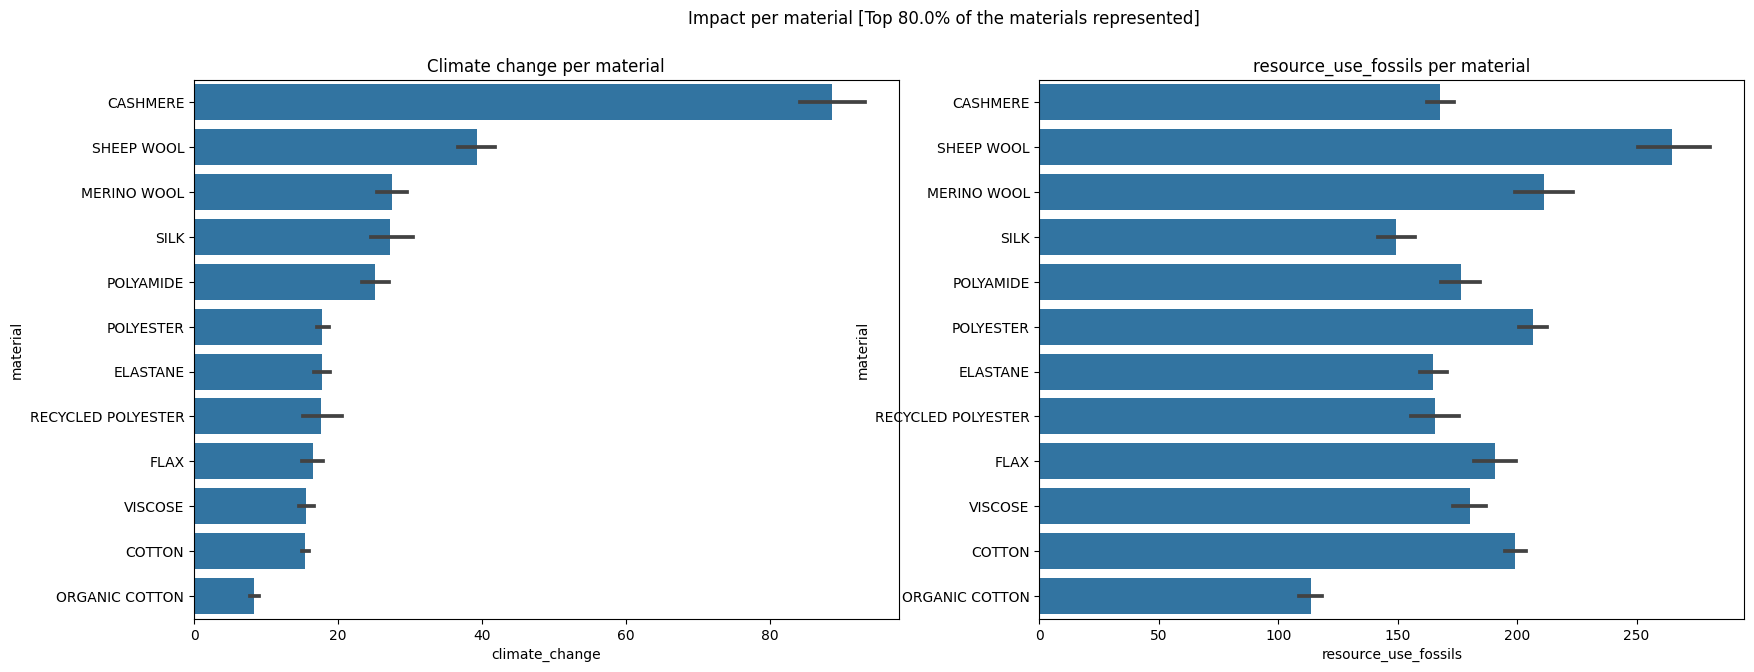

In [163]:
df_ = df_raw.copy()

unnested_material = df_['composition'].str.split(', ', expand=True).stack()

material_selected = unnested_material.value_counts()[0:12].index
selection_ratio = unnested_material.value_counts()[0:12].values.sum()/unnested_material.value_counts().values.sum()

material_df = pd.DataFrame(df_['composition'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True))
material_df.columns = ['material']

df_merged = pd.merge(material_df, df_[['climate_change', 'resource_use_fossils']], left_index=True, right_index=True, how='left')
df_merged = df_merged[df_merged['material'].isin(material_selected)]

order = df_merged.groupby(['material']).agg({'climate_change':'mean'}).sort_values(['climate_change'], ascending=False).index


fig, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.barplot(df_merged, x='climate_change', y='material', order=order, color='tab:blue', errorbar='ci', ax=ax[0])
ax[0].set_title('Climate change per material')

sns.barplot(df_merged, x='resource_use_fossils', y='material', order=order, color='tab:blue', errorbar='ci', ax=ax[1])
ax[1].set_title('resource_use_fossils per material')

fig.suptitle(f"Impact per material [Top {round(selection_ratio*100,0)}% of the materials represented]")

plt.show()

### Impact per country

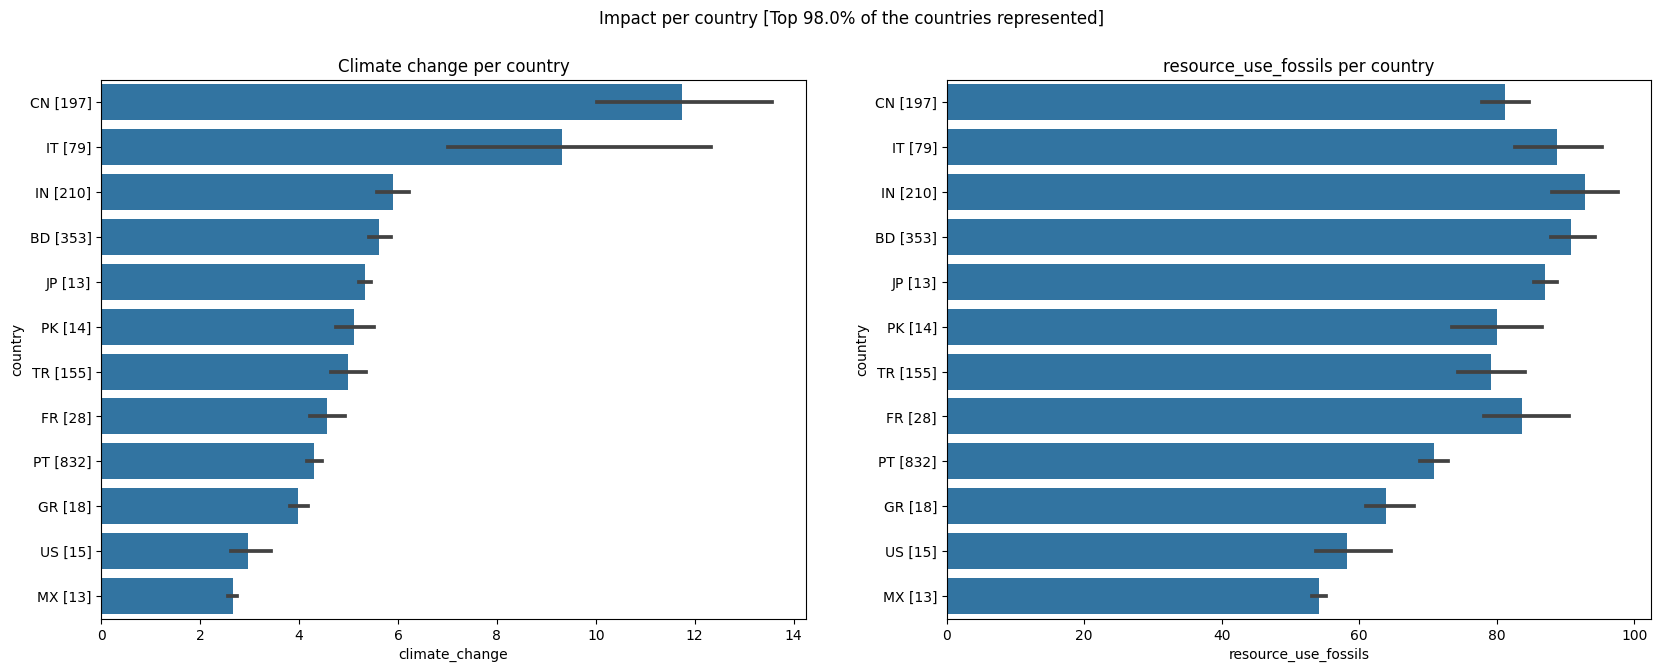

In [268]:
df_ = df_raw.copy()

df_ = df_[df_['product_type'] == 'TSHIRTS']


df_['countries'] = df_['manufacturing_country'].astype(str) + ' ' \
                    + df_['dyeing_country'].astype(str) + ' ' \
                    + df_['weaving_country'].astype(str) + ' ' \
                    + df_['raw_material_country'].astype(str)

df_['countries'] = df_['countries'].str.replace(',', '')

unnested_countries = df_['countries'].str.split(' ', expand=True).stack()
unnested_countries = unnested_countries[unnested_countries != 'nan']

countries_selected = unnested_countries.value_counts()[0:12].index.to_list()
selection_ratio = unnested_countries.value_counts()[0:12].values.sum()/unnested_countries.value_counts().values.sum()

country_df = pd.DataFrame(df_['countries'].str.split(' ', expand=True).stack().reset_index(level=1, drop=True))
country_df.columns = ['country']

df_merged = pd.merge(country_df, df_[['climate_change', 'resource_use_fossils']], left_index=True, right_index=True, how='left')
df_merged = df_merged[df_merged['country'].isin(countries_selected)]

country_count = df_merged['country'].value_counts()
country_count.columns = ['count']
df_merged = pd.merge(df_merged, country_count, left_on='country', right_index=True, how='left')
df_merged['country'] = df_merged['country'] + ' [' + df_merged['count'].astype(str) + ']'

order = df_merged.groupby(['country']).agg({'climate_change':'mean'}).sort_values(['climate_change'], ascending=False).index


fig, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.barplot(df_merged, x='climate_change', y='country', order=order, color='tab:blue', errorbar='ci', ax=ax[0])
ax[0].set_title('Climate change per country')

sns.barplot(df_merged, x='resource_use_fossils', y='country', order=order, color='tab:blue', errorbar='ci', ax=ax[1])
ax[1].set_title('resource_use_fossils per country')

fig.suptitle(f"Impact per country [Top {round(selection_ratio*100,0)}% of the countries represented]")

plt.show()

### Impact per country and per technique

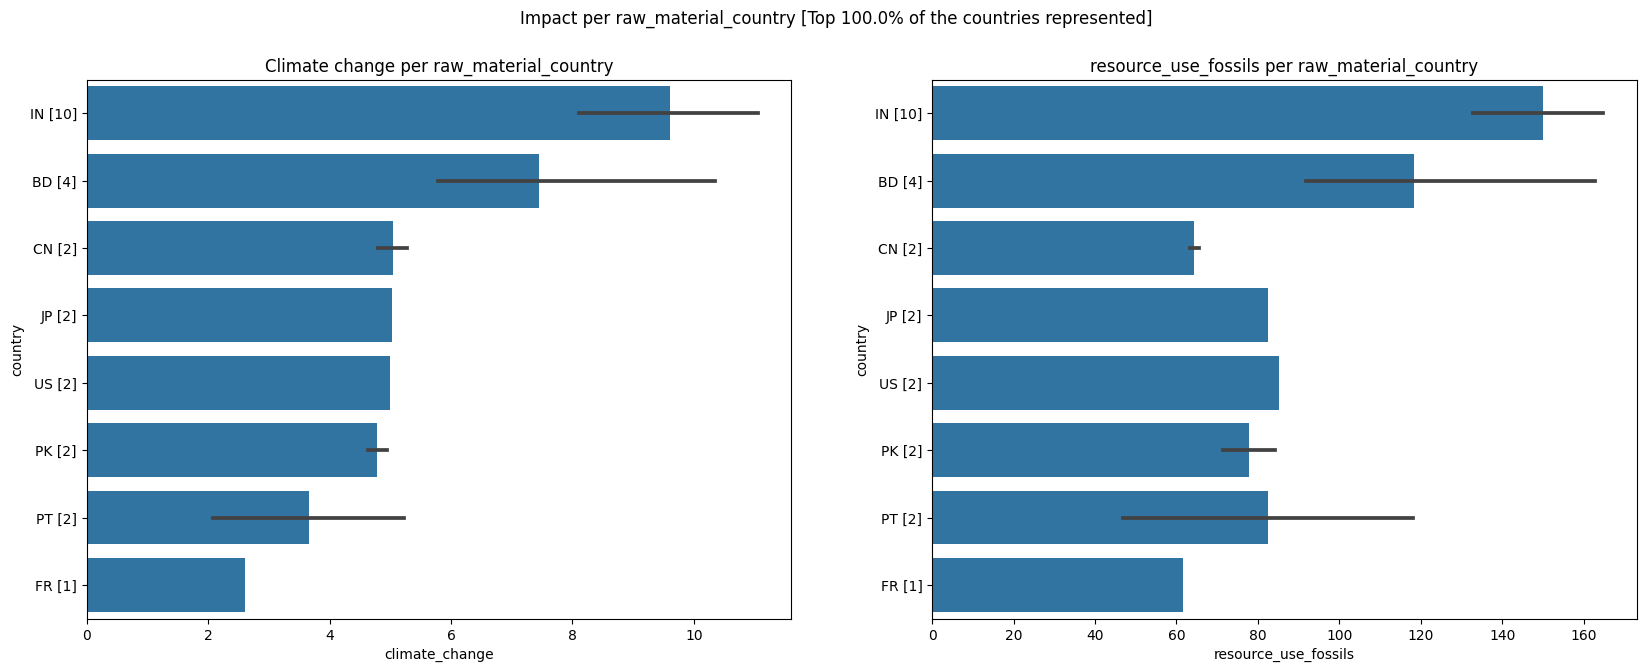

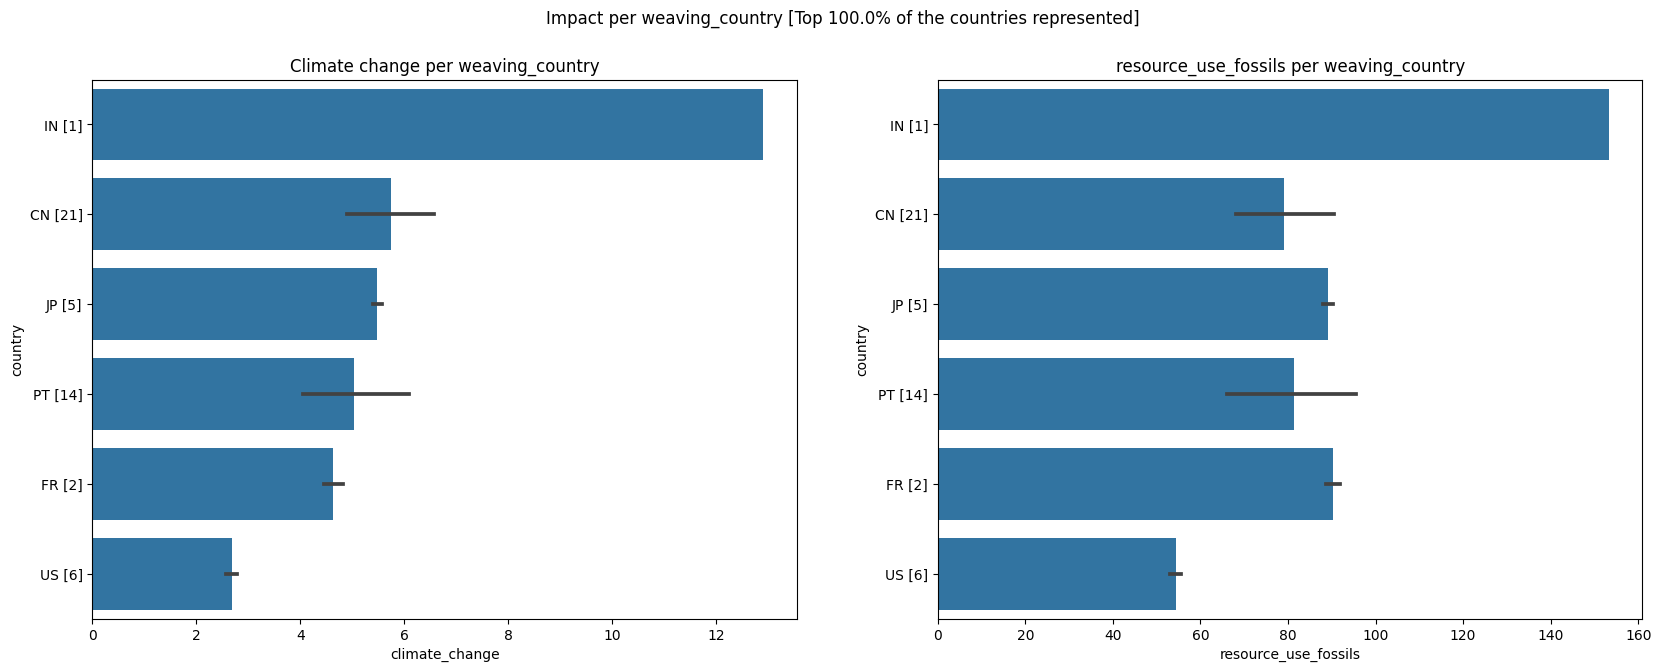

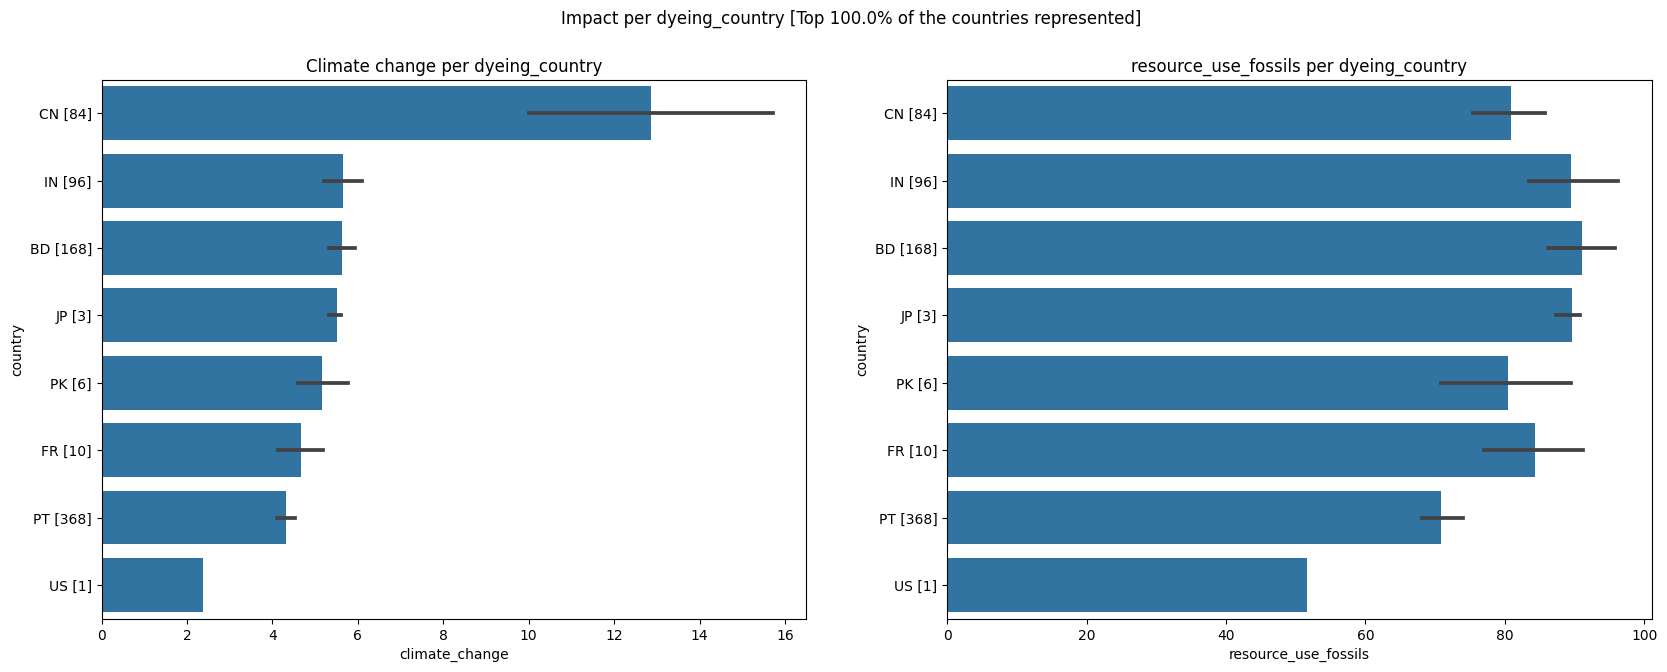

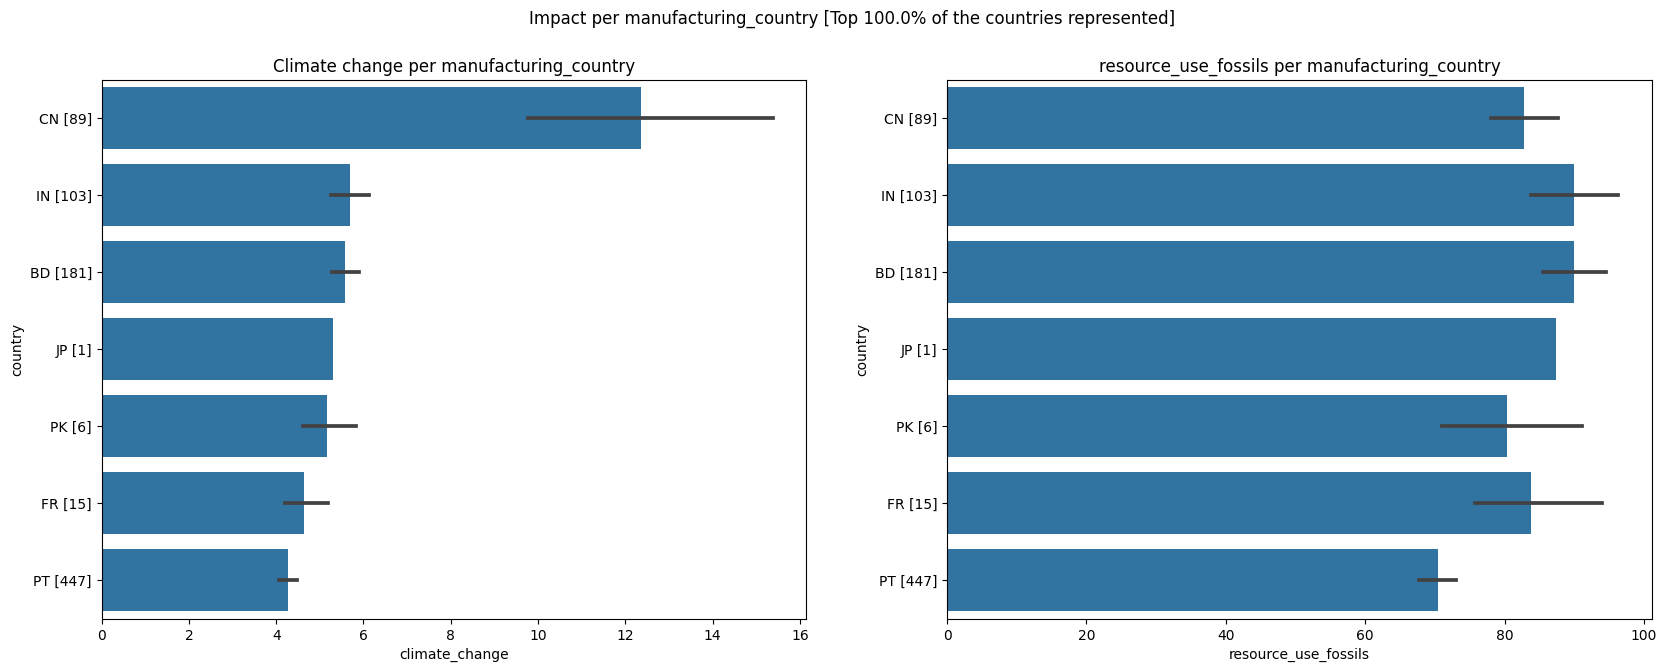

In [267]:
for col in ['raw_material_country', 'weaving_country', 'dyeing_country', 'manufacturing_country']: 
    df_ = df_raw.copy()

    df_ = df_[df_['product_type'] == 'TSHIRTS']
    
    df_['countries'] = df_[col].astype(str)
    unnested_countries = unnested_countries[unnested_countries != 'nan']
    
    countries_selected = unnested_countries.value_counts()[0:12].index.to_list()
    selection_ratio = unnested_countries.value_counts()[0:12].values.sum()/unnested_countries.value_counts().values.sum()
    
    country_df = pd.DataFrame(df_['countries'].str.split(' ', expand=True).stack().reset_index(level=1, drop=True))
    country_df.columns = ['country']
    
    df_merged = pd.merge(country_df, df_[['climate_change', 'resource_use_fossils']], left_index=True, right_index=True, how='left')
    df_merged = df_merged[df_merged['country'].isin(countries_selected)]

    country_count = df_merged['country'].value_counts()
    country_count.columns = ['count']
    df_merged = pd.merge(df_merged, country_count, left_on='country', right_index=True, how='left')
    df_merged['country'] = df_merged['country'] + ' [' + df_merged['count'].astype(str) + ']'
    
    order = df_merged.groupby(['country']).agg({'climate_change':'mean'}).sort_values(['climate_change'], ascending=False).index
    
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    sns.barplot(df_merged, x='climate_change', y='country', order=order, color='tab:blue', errorbar='ci', ax=ax[0])
    ax[0].set_title(f'Climate change per {col}')
    
    sns.barplot(df_merged, x='resource_use_fossils', y='country', order=order, color='tab:blue', errorbar='ci', ax=ax[1])
    ax[1].set_title(f'resource_use_fossils per {col}')
    
    fig.suptitle(f"Impact per {col} [Top {round(selection_ratio*100,0)}% of the countries represented]")
    
    plt.show()